In [12]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_35.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_35.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

In [13]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [14]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [15]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [16]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [17]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


In [18]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:06<00:00,  3.46it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:25<00:00,  2.85it/s]


In [19]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   2%|▏         | 9/500 [00:03<02:05,  3.91it/s]

Epoch 10/500, Loss: 0.8924
Test Accuracy at Epoch 10: 57.74%
Test F1-score at Epoch 10: 0.3925
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.56      0.86      0.68       195
non_infringement       0.66      0.28      0.39       186

        accuracy                           0.58       381
       macro avg       0.61      0.57      0.53       381
    weighted avg       0.61      0.58      0.54       381

New best model saved with F1-score 0.3925 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.56      0.86      0.68       195
non_infringement       0.66      0.28      0.39       186

        accuracy                           0.58       381
       macro avg       0.61      0.57      0.53       381
    weighted avg       0.61      0.58      0.54       381



Training Epochs:   4%|▍         | 19/500 [00:04<01:00,  8.02it/s]

Epoch 20/500, Loss: 0.4806
Test Accuracy at Epoch 20: 57.22%
Test F1-score at Epoch 20: 0.4725
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.56      0.74      0.64       195
non_infringement       0.59      0.39      0.47       186

        accuracy                           0.57       381
       macro avg       0.58      0.57      0.56       381
    weighted avg       0.58      0.57      0.56       381

New best model saved with F1-score 0.4725 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.56      0.74      0.64       195
non_infringement       0.59      0.39      0.47       186

        accuracy                           0.57       381
       macro avg       0.58      0.57      0.56       381
    weighted avg       0.58      0.57      0.56       381



Training Epochs:   6%|▌         | 30/500 [00:08<02:50,  2.75it/s]

Epoch 30/500, Loss: 0.4949
Test Accuracy at Epoch 30: 64.83%
Test F1-score at Epoch 30: 0.7087
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.79      0.43      0.56       195
non_infringement       0.59      0.88      0.71       186

        accuracy                           0.65       381
       macro avg       0.69      0.65      0.63       381
    weighted avg       0.69      0.65      0.63       381

New best model saved with F1-score 0.7087 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.79      0.43      0.56       195
non_infringement       0.59      0.88      0.71       186

        accuracy                           0.65       381
       macro avg       0.69      0.65      0.63       381
    weighted avg       0.69      0.65      0.63       381



Training Epochs:   9%|▊         | 43/500 [00:12<01:28,  5.16it/s]

Epoch 40/500, Loss: 0.4609
Test Accuracy at Epoch 40: 64.83%
Test F1-score at Epoch 40: 0.6278
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.65      0.69      0.67       195
non_infringement       0.65      0.61      0.63       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  11%|█         | 53/500 [00:12<00:34, 13.11it/s]

Epoch 50/500, Loss: 0.4440
Test Accuracy at Epoch 50: 67.45%
Test F1-score at Epoch 50: 0.6946
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       195
non_infringement       0.64      0.76      0.69       186

        accuracy                           0.67       381
       macro avg       0.68      0.68      0.67       381
    weighted avg       0.68      0.67      0.67       381



Training Epochs:  12%|█▏        | 62/500 [00:13<00:26, 16.23it/s]

Epoch 60/500, Loss: 0.4221
Test Accuracy at Epoch 60: 65.09%
Test F1-score at Epoch 60: 0.6491
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.66      0.64      0.65       195
non_infringement       0.64      0.66      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  14%|█▍        | 70/500 [00:13<00:38, 11.23it/s]

Epoch 70/500, Loss: 0.3958
Test Accuracy at Epoch 70: 66.40%
Test F1-score at Epoch 70: 0.6768
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       195
non_infringement       0.64      0.72      0.68       186

        accuracy                           0.66       381
       macro avg       0.67      0.67      0.66       381
    weighted avg       0.67      0.66      0.66       381



Training Epochs:  16%|█▌        | 81/500 [00:15<00:38, 10.94it/s]

Epoch 80/500, Loss: 0.3685
Test Accuracy at Epoch 80: 67.72%
Test F1-score at Epoch 80: 0.6917
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       195
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:  18%|█▊        | 90/500 [00:18<02:45,  2.48it/s]

Epoch 90/500, Loss: 0.3398
Test Accuracy at Epoch 90: 67.45%
Test F1-score at Epoch 90: 0.6884
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       195
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.67       381
       macro avg       0.68      0.68      0.67       381
    weighted avg       0.68      0.67      0.67       381



Training Epochs:  20%|█▉        | 99/500 [00:19<00:46,  8.57it/s]

Epoch 100/500, Loss: 0.3137
Test Accuracy at Epoch 100: 66.40%
Test F1-score at Epoch 100: 0.6667
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       195
non_infringement       0.65      0.69      0.67       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.67      0.66      0.66       381



Training Epochs:  22%|██▏       | 110/500 [00:23<02:01,  3.20it/s]

Epoch 110/500, Loss: 0.2902
Test Accuracy at Epoch 110: 66.40%
Test F1-score at Epoch 110: 0.6614
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  24%|██▍       | 122/500 [00:27<01:18,  4.82it/s]

Epoch 120/500, Loss: 0.2683
Test Accuracy at Epoch 120: 66.40%
Test F1-score at Epoch 120: 0.6614
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  26%|██▋       | 132/500 [00:28<00:30, 12.00it/s]

Epoch 130/500, Loss: 0.2472
Test Accuracy at Epoch 130: 65.88%
Test F1-score at Epoch 130: 0.6579
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.67      0.65      0.66       195
non_infringement       0.64      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  28%|██▊       | 142/500 [00:29<00:18, 19.29it/s]

Epoch 140/500, Loss: 0.3123
Test Accuracy at Epoch 140: 70.87%
Test F1-score at Epoch 140: 0.7550
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.87      0.51      0.64       195
non_infringement       0.64      0.92      0.75       186

        accuracy                           0.71       381
       macro avg       0.75      0.71      0.70       381
    weighted avg       0.76      0.71      0.70       381

New best model saved with F1-score 0.7550 at epoch 140
Best Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.87      0.51      0.64       195
non_infringement       0.64      0.92      0.75       186

        accuracy                           0.71       381
       macro avg       0.75      0.71      0.70       381
    weighted avg       0.76      0.71      0.70       381



Training Epochs:  31%|███       | 154/500 [00:29<00:12, 27.46it/s]

Epoch 150/500, Loss: 0.2429
Test Accuracy at Epoch 150: 70.60%
Test F1-score at Epoch 150: 0.7321
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       195
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.70       381
    weighted avg       0.72      0.71      0.70       381



Training Epochs:  33%|███▎      | 164/500 [00:30<00:15, 22.08it/s]

Epoch 160/500, Loss: 0.2160
Test Accuracy at Epoch 160: 65.09%
Test F1-score at Epoch 160: 0.6376
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.66      0.67      0.66       195
non_infringement       0.65      0.63      0.64       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  34%|███▍      | 171/500 [00:30<00:12, 25.96it/s]

Epoch 170/500, Loss: 0.2123
Test Accuracy at Epoch 170: 66.14%
Test F1-score at Epoch 170: 0.6596
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.68      0.65      0.66       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  36%|███▌      | 179/500 [00:34<01:41,  3.18it/s]

Epoch 180/500, Loss: 0.1876
Test Accuracy at Epoch 180: 65.35%
Test F1-score at Epoch 180: 0.6471
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       195
non_infringement       0.64      0.65      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  38%|███▊      | 192/500 [00:35<00:33,  9.28it/s]

Epoch 190/500, Loss: 0.2012
Test Accuracy at Epoch 190: 66.40%
Test F1-score at Epoch 190: 0.6684
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       195
non_infringement       0.65      0.69      0.67       186

        accuracy                           0.66       381
       macro avg       0.67      0.66      0.66       381
    weighted avg       0.67      0.66      0.66       381



Training Epochs:  40%|████      | 202/500 [00:36<00:18, 15.89it/s]

Epoch 200/500, Loss: 0.1671
Test Accuracy at Epoch 200: 65.88%
Test F1-score at Epoch 200: 0.6615
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       195
non_infringement       0.64      0.68      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  42%|████▏     | 211/500 [00:36<00:15, 18.66it/s]

Epoch 210/500, Loss: 0.1579
Test Accuracy at Epoch 210: 67.45%
Test F1-score at Epoch 210: 0.6884
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       195
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.67       381
       macro avg       0.68      0.68      0.67       381
    weighted avg       0.68      0.67      0.67       381



Training Epochs:  45%|████▍     | 223/500 [00:37<00:12, 21.35it/s]

Epoch 220/500, Loss: 0.1862
Test Accuracy at Epoch 220: 68.77%
Test F1-score at Epoch 220: 0.7160
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.76      0.57      0.65       195
non_infringement       0.64      0.81      0.72       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.68       381
    weighted avg       0.70      0.69      0.68       381



Training Epochs:  47%|████▋     | 234/500 [00:37<00:09, 26.85it/s]

Epoch 230/500, Loss: 0.1763
Test Accuracy at Epoch 230: 66.40%
Test F1-score at Epoch 230: 0.6649
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.68      0.65      0.66       195
non_infringement       0.65      0.68      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  49%|████▊     | 243/500 [00:37<00:09, 28.32it/s]

Epoch 240/500, Loss: 0.1352
Test Accuracy at Epoch 240: 64.83%
Test F1-score at Epoch 240: 0.6319
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.65      0.68      0.66       195
non_infringement       0.65      0.62      0.63       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  50%|█████     | 252/500 [00:38<00:07, 33.14it/s]

Epoch 250/500, Loss: 0.1329
Test Accuracy at Epoch 250: 65.09%
Test F1-score at Epoch 250: 0.6415
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       195
non_infringement       0.64      0.64      0.64       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  52%|█████▏    | 261/500 [00:38<00:08, 28.44it/s]

Epoch 260/500, Loss: 0.1281
Test Accuracy at Epoch 260: 65.35%
Test F1-score at Epoch 260: 0.6471
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       195
non_infringement       0.64      0.65      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  54%|█████▍    | 270/500 [00:41<00:44,  5.12it/s]

Epoch 270/500, Loss: 0.1264
Test Accuracy at Epoch 270: 65.62%
Test F1-score at Epoch 270: 0.6597
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       195
non_infringement       0.64      0.68      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  56%|█████▌    | 280/500 [00:46<01:36,  2.28it/s]

Epoch 280/500, Loss: 0.1196
Test Accuracy at Epoch 280: 66.14%
Test F1-score at Epoch 280: 0.6684
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.65       195
non_infringement       0.64      0.70      0.67       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  58%|█████▊    | 290/500 [00:51<01:54,  1.84it/s]

Epoch 290/500, Loss: 0.1173
Test Accuracy at Epoch 290: 66.14%
Test F1-score at Epoch 290: 0.6632
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       195
non_infringement       0.64      0.68      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  60%|██████    | 301/500 [00:53<00:26,  7.56it/s]

Epoch 300/500, Loss: 0.1157
Test Accuracy at Epoch 300: 66.14%
Test F1-score at Epoch 300: 0.6632
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       195
non_infringement       0.64      0.68      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  62%|██████▏   | 312/500 [00:54<00:11, 16.37it/s]

Epoch 310/500, Loss: 0.1141
Test Accuracy at Epoch 310: 65.88%
Test F1-score at Epoch 310: 0.6615
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       195
non_infringement       0.64      0.68      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  65%|██████▍   | 323/500 [00:54<00:07, 22.72it/s]

Epoch 320/500, Loss: 0.1165
Test Accuracy at Epoch 320: 65.35%
Test F1-score at Epoch 320: 0.6526
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       195
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  66%|██████▋   | 332/500 [00:54<00:05, 30.41it/s]

Epoch 330/500, Loss: 0.1164
Test Accuracy at Epoch 330: 65.62%
Test F1-score at Epoch 330: 0.6749
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.70      0.58      0.64       195
non_infringement       0.63      0.73      0.67       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.65       381



Training Epochs:  68%|██████▊   | 342/500 [00:56<00:21,  7.44it/s]

Epoch 340/500, Loss: 0.1157
Test Accuracy at Epoch 340: 65.88%
Test F1-score at Epoch 340: 0.6632
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       195
non_infringement       0.64      0.69      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  70%|███████   | 351/500 [00:57<00:12, 11.75it/s]

Epoch 350/500, Loss: 0.1124
Test Accuracy at Epoch 350: 65.35%
Test F1-score at Epoch 350: 0.6526
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       195
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  73%|███████▎  | 366/500 [00:57<00:06, 22.19it/s]

Epoch 360/500, Loss: 0.1120
Test Accuracy at Epoch 360: 65.09%
Test F1-score at Epoch 360: 0.6683
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.69      0.58      0.63       195
non_infringement       0.62      0.72      0.67       186

        accuracy                           0.65       381
       macro avg       0.66      0.65      0.65       381
    weighted avg       0.66      0.65      0.65       381



Training Epochs:  74%|███████▍  | 370/500 [00:58<00:05, 25.01it/s]

Epoch 370/500, Loss: 0.1134
Test Accuracy at Epoch 370: 66.40%
Test F1-score at Epoch 370: 0.6614
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  76%|███████▋  | 382/500 [00:59<00:08, 13.65it/s]

Epoch 380/500, Loss: 0.1133
Test Accuracy at Epoch 380: 65.35%
Test F1-score at Epoch 380: 0.6526
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       195
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  78%|███████▊  | 390/500 [01:01<00:28,  3.89it/s]

Epoch 390/500, Loss: 0.1118
Test Accuracy at Epoch 390: 66.40%
Test F1-score at Epoch 390: 0.6614
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  80%|████████  | 401/500 [01:05<00:18,  5.42it/s]

Epoch 400/500, Loss: 0.1107
Test Accuracy at Epoch 400: 65.35%
Test F1-score at Epoch 400: 0.6526
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       195
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  82%|████████▏ | 410/500 [01:07<00:20,  4.46it/s]

Epoch 410/500, Loss: 0.1116
Test Accuracy at Epoch 410: 66.40%
Test F1-score at Epoch 410: 0.6614
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  85%|████████▍ | 424/500 [01:10<00:06, 11.69it/s]

Epoch 420/500, Loss: 0.1117
Test Accuracy at Epoch 420: 65.62%
Test F1-score at Epoch 420: 0.6525
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.67      0.65      0.66       195
non_infringement       0.64      0.66      0.65       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  87%|████████▋ | 435/500 [01:10<00:02, 21.74it/s]

Epoch 430/500, Loss: 0.1105
Test Accuracy at Epoch 430: 66.40%
Test F1-score at Epoch 430: 0.6614
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  89%|████████▊ | 443/500 [01:10<00:02, 26.02it/s]

Epoch 440/500, Loss: 0.1087
Test Accuracy at Epoch 440: 64.83%
Test F1-score at Epoch 440: 0.6474
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.66      0.64      0.65       195
non_infringement       0.63      0.66      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



Training Epochs:  90%|█████████ | 451/500 [01:11<00:03, 14.16it/s]

Epoch 450/500, Loss: 0.1086
Test Accuracy at Epoch 450: 66.40%
Test F1-score at Epoch 450: 0.6614
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.67      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  93%|█████████▎| 463/500 [01:12<00:02, 18.16it/s]

Epoch 460/500, Loss: 0.1102
Test Accuracy at Epoch 460: 65.88%
Test F1-score at Epoch 460: 0.6543
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.67      0.66      0.66       195
non_infringement       0.65      0.66      0.65       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  94%|█████████▍| 472/500 [01:12<00:01, 18.09it/s]

Epoch 470/500, Loss: 0.1064
Test Accuracy at Epoch 470: 66.67%
Test F1-score at Epoch 470: 0.6649
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       195
non_infringement       0.65      0.68      0.66       186

        accuracy                           0.67       381
       macro avg       0.67      0.67      0.67       381
    weighted avg       0.67      0.67      0.67       381



Training Epochs:  97%|█████████▋| 484/500 [01:14<00:01, 12.97it/s]

Epoch 480/500, Loss: 0.1082
Test Accuracy at Epoch 480: 66.40%
Test F1-score at Epoch 480: 0.6632
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.68      0.65      0.66       195
non_infringement       0.65      0.68      0.66       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:  98%|█████████▊| 489/500 [01:14<00:00, 15.65it/s]

Epoch 490/500, Loss: 0.1091
Test Accuracy at Epoch 490: 65.88%
Test F1-score at Epoch 490: 0.6782
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.70      0.58      0.64       195
non_infringement       0.63      0.74      0.68       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs: 100%|██████████| 500/500 [01:18<00:00,  6.35it/s]
/tmp/ipykernel_4114113/1789105606.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.1183
Test Accuracy at Epoch 500: 65.35%
Test F1-score at Epoch 500: 0.6471
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       195
non_infringement       0.64      0.65      0.65       186

        accuracy                           0.65       381
       macro avg       0.65      0.65      0.65       381
    weighted avg       0.65      0.65      0.65       381



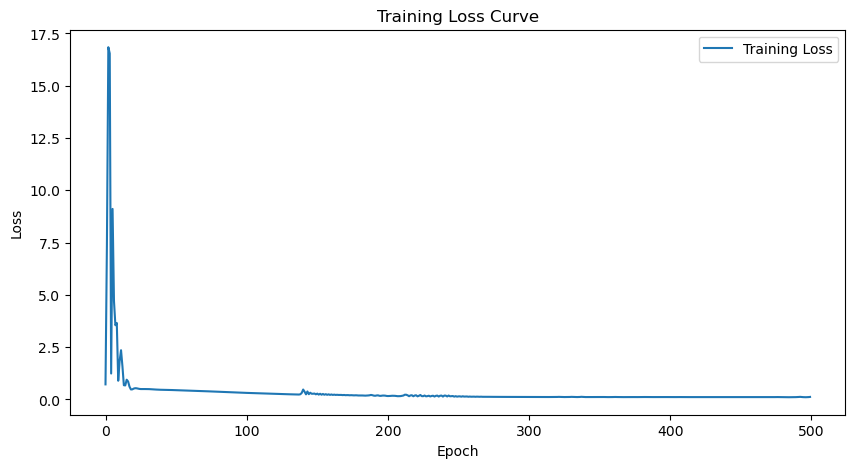

Best Model was saved at epoch 140 with F1-score 0.7550 and accuracy 70.87%


In [20]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [21]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 70.87%


/tmp/ipykernel_4114113/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.87      0.51      0.64       195
non_infringement       0.64      0.92      0.75       186

        accuracy                           0.71       381
       macro avg       0.75      0.71      0.70       381
    weighted avg       0.76      0.71      0.70       381



: 